In [2]:
from fastai.vision.all import *
import fastai
import timm
import pandas as pd

In [3]:
import torch
torch.cuda.set_device(1)

In [4]:
df = pd.read_csv('../dataset.csv')

In [5]:
df = df.drop(df[df.masa<0].index)

In [6]:
dftrain = df[(df.split=='train') | (df.split=='valid')]
dftest = df[(df.split=='test')]

In [7]:
# !mkdir ../datasetClean/train
# !mkdir ../datasetClean/test

In [8]:
# import shutil
# from imutils import paths

In [9]:
# for image in dftrain.image_id.values:
#     shutil.move(image.replace('datasetClean','../datasetClean'),
#                 image.replace('datasetClean','../datasetClean/train'))

In [10]:
# for image in dftest.image_id.values:
#     shutil.move(image.replace('datasetClean','../datasetClean'),
#                 image.replace('datasetClean','../datasetClean/test'))

In [11]:
# df.volumen.describe()

In [12]:
def get_masa(f):
    return float(df[df['image_id']=='datasetClean/'+f.name]['masa'])

def get_volumen(f):
    return float(df[df['image_id']=='datasetClean/'+f.name]['volumen'])

def is_valid(f):
    return (df[df['image_id']=='datasetClean/'+f.name]['split']).values[0]=='valid'

In [13]:
def getDataBlock(presize=512,size=512):
    return DataBlock(blocks = (ImageBlock, RegressionBlock()),
                 get_items=get_image_files, 
                 splitter=FuncSplitter(is_valid),
                 get_y=get_volumen,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size,flip_vert=True,
                                            max_zoom=1.0), Normalize.from_stats(*imagenet_stats)])

In [14]:
path = Path('../datasetClean/')
trainPath = path/'train'

In [15]:
db = getDataBlock()
dls = db.dataloaders(trainPath,bs=16)

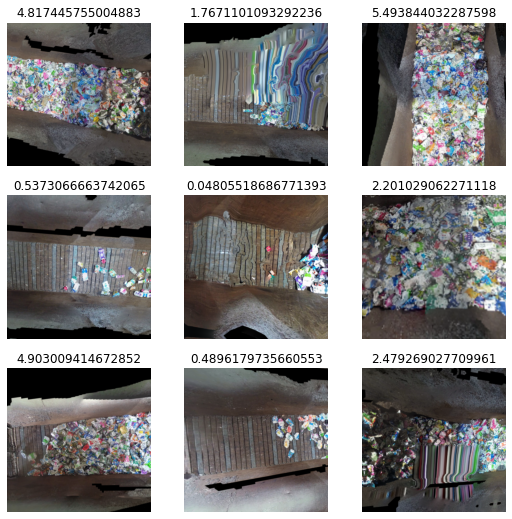

In [16]:
dls.show_batch()

In [17]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnetrs50')
]

In [18]:
from fastai.metrics import mae

In [20]:
??cnn_learner

In [21]:
learn = Learner(dls, timm.create_model('resnetrs50',num_classes=1,pretrained=True),
                loss_func=MSELossFlat(), metrics=mae,cbs=callbacks).to_fp16()

In [19]:
# learn.lr_find()

epoch,train_loss,valid_loss,mae,time
0,8.629111,1.662623,1.009316,00:09


Better model found at epoch 0 with valid_loss value: 1.6626228094100952.


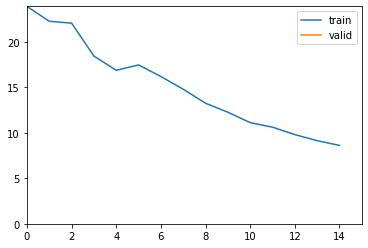

epoch,train_loss,valid_loss,mae,time
0,1.489238,1.365134,0.856323,00:06
1,1.239489,1.052299,0.786677,00:06
2,1.213384,1.254586,0.956628,00:06
3,1.164253,0.516585,0.583187,00:06
4,1.024519,0.651917,0.605616,00:06
5,0.895131,0.409847,0.484426,00:07
6,0.828372,0.303870,0.423432,00:06
7,0.768454,0.760406,0.629667,00:06
8,0.803469,0.719966,0.598630,00:06
9,0.754581,0.407748,0.468886,00:07


Better model found at epoch 0 with valid_loss value: 1.3651344776153564.


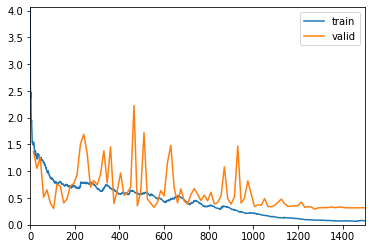

Better model found at epoch 1 with valid_loss value: 1.0522993803024292.
Better model found at epoch 3 with valid_loss value: 0.5165854692459106.
Better model found at epoch 5 with valid_loss value: 0.40984657406806946.
Better model found at epoch 6 with valid_loss value: 0.30386993288993835.
Better model found at epoch 84 with valid_loss value: 0.29114362597465515.


In [22]:
learn.fine_tune(100,base_lr=1e-3)

In [30]:
def is_test(f):
    return (df[df['image_id']=='datasetClean/'+f.name]['split']).values[0]=='test'

In [31]:
dbtest = DataBlock(blocks = (ImageBlock, RegressionBlock()),
                 get_items=get_image_files, 
                 splitter=FuncSplitter(is_test),
                 get_y=get_volumen,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=512,flip_vert=True,
                                            max_zoom=1.0), Normalize.from_stats(*imagenet_stats)])

In [32]:
dlstest = dbtest.dataloaders(path,bs=16)

In [33]:
learn.dls=dlstest

In [34]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.4565006494522095.


(#2) [0.6249816417694092,0.4565006494522095]